In [1]:
import numpy as np
import pandas as pd
import os 
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

2024-03-27 11:20:29.683420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# testing on one image
model = ResNet50(weights='imagenet', include_top=False)
img_path = 'test_images/0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
embedding = model.predict(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [15]:
# i was expecting a vector
# embedding

In [10]:
type(embedding)

numpy.ndarray

In [16]:
# number of dimensions
embedding.ndim

4

In [17]:
# shape of each dimension
embedding.shape

(1, 7, 7, 2048)

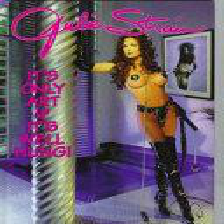

In [18]:
img

In [19]:
directory = 'test_images'
image_name_list = os.listdir(directory)

In [20]:
image_name_list

['8.jpg', '10.jpg', '5.jpg', '2.jpg', '3.jpg', '1.jpg', '0.jpg']

In [9]:
image_array_list = []

for image_name in image_name_list:
    directory = 'test_images'
    img_path = os.path.join(directory, image_name)
    img = keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = keras.utils.img_to_array(img)
    
    image_array_list.append(img_array)

# Create a DataFrame
df = pd.DataFrame({
    'ImageName': image_name_list,
    'ImageArray': image_array_list
})

# Print the DataFrame
print(df)

  ImageName                                         ImageArray
0     8.jpg  [[[18.0, 156.0, 130.0], [18.0, 156.0, 130.0], ...
1    10.jpg  [[[30.0, 31.0, 33.0], [30.0, 31.0, 33.0], [30....
2     5.jpg  [[[162.0, 136.0, 87.0], [162.0, 136.0, 87.0], ...
3     2.jpg  [[[238.0, 176.0, 125.0], [238.0, 176.0, 125.0]...
4     3.jpg  [[[111.0, 93.0, 117.0], [111.0, 93.0, 117.0], ...
5     1.jpg  [[[169.0, 193.0, 231.0], [169.0, 193.0, 231.0]...
6     0.jpg  [[[184.0, 91.0, 195.0], [184.0, 91.0, 195.0], ...


In [21]:
embedding_list = []

for image_name in image_name_list:
    model = ResNet50(weights='imagenet', include_top=False)
    directory = 'test_images'
    img_path = os.path.join(directory, image_name)
    img = image.load_img(img_path, target_size=(224, 224))    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = model.predict(x)
    embedding_list.append(embedding)

# Create a DataFrame
df = pd.DataFrame({
    'ImageName': image_name_list,
    'Embedding': embedding_list
})

# Print the DataFrame
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
  ImageName                                          Embedding
0     8.jpg  [[[[0.        0.        0.        ... 1.262943...
1    10.jpg  [[[[0. 0. 0. ... 0. 0. 0.], [0.00348517 0.    ...
2     5.jpg  [[[[ 0.        0.        0.       ... 12.92060...
3     2.jpg  [[[[0.         0.         0.         ... 0.837...
4     3.jpg  [[[[0. 0. 0. ... 0. 0. 0.], [0. 0. 0. ... 0. 0...
5     1.jpg  [[[[0. 0. 0. ... 0. 0. 0.], [0. 0. 0. ... 0. 0...
6     0.jpg  [[[[0.        2.6630778 0.        ... 0.      ...
